# Step 0: Preface

We have prepared pre-trained models for Flickr30k dataset as the example. Therefore, you don't need to train the model from scratch, which can save time. Hoever, if you would like to run the model with transformer+pretrained word2vector, you need to download GloVe dataset, which can be time-consuming. Alternatively, you can go through the code without pre-trained word2vec

To evaluate and visualise result, you need to download dataset from Kaggle using shell commands below and load the pretrained model (transformer/LSTM+Atttention/LSTM) from your appointed `save_path`.

To jump to the final result, go to **Step 6**.

# Step 1: Set up Kaggle API and download dataset

Please note that you need to upload **kaggle.json** provided in a separate share folder in order to download dataset from Kaggle.

In [0]:
# Run this cell and select the kaggle.json file downloaded
# from the Kaggle account settings page.
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"dongdongchenethan","key":"dadec295b0280098fa23c4abcff4c27c"}'}

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
!pip install torchtext==0.5.0

In [0]:
# Next, install the Kaggle API client.
!pip install -q kaggle

In [0]:
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

## Download Flickr30k

In [0]:
# Download from Kaggle
!kaggle datasets download -d hsankesara/flickr-image-dataset

100% 8.16G/8.16G [03:11<00:00, 26.3MB/s]
100% 8.16G/8.16G [03:11<00:00, 45.9MB/s]


In [0]:
# Unzip dataset
!unzip flickr-image-dataset.zip

In [0]:
!rm flickr-image-dataset.zip
!rm -r flickr30k_images/flickr30k_images/flickr30k_images
!rm flickr30k_images/flickr30k_images/results.csv

## Download 102Flowers

In [0]:
!kaggle datasets download -d wassimseifeddine/102flowersdataset

In [0]:
!unzip 102flowersdataset.zip
!rm 102flowersdataset.zip

In [0]:
!tar zxvf 102flowers.tgz
!rm 102flowers.tgz

## Download CUB

In [0]:
# Download from Kaggle
!kaggle datasets download -d veeralakrishna/200-bird-species-with-11788-images

In [0]:
!unzip 200-bird-species-with-11788-images.zip
!rm 200-bird-species-with-11788-images.zip

In [0]:
!tar zxvf CUB_200_2011.tgz
!rm CUB_200_2011.tgz

In [0]:
!tar zxvf segmentations.tgz
!rm segmentations.tgz

## Import modules

In [0]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, Subset
import torchtext
from torchtext.data import get_tokenizer, Field
from torchtext.data.metrics import bleu_score
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.nn import TransformerEncoder, TransformerEncoderLayer, TransformerDecoder, TransformerDecoderLayer
import os
import gc
import math
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import models

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [0]:
torchtext.__version__

'0.5.0'

# Step 2: Load Dataset

Change `save_path` to your path where the pretrained models are saved to.

## Load Flickr30k

In [0]:
# Colab
data_path = 'flickr30k_images/flickr30k_images'
csv_path = 'flickr30k_images/results.csv'
save_path = 'pretrained_models'

In [0]:
results = pd.read_csv(csv_path, sep='|')
fix_19999 = results.loc[19999][' comment_number']
results.loc[19999][' comment_number'] = ' 4'
results.loc[19999][' comment'] = fix_19999[4:]
results = results.sort_values(by=[' comment_number', 'image_name', ])
results

,image_name,comment_number,comment
0,1000092795.jpg,0,Two young guys with shaggy hair look at their...
5,10002456.jpg,0,Several men in hard hats are operating a gian...
10,1000268201.jpg,0,A child in a pink dress is climbing up a set ...
15,1000344755.jpg,0,Someone in a blue shirt and hat is standing o...
20,1000366164.jpg,0,"Two men , one in a gray shirt , one in a blac..."
...,...,...,...
158894,997338199.jpg,4,A person stands near golden walls .
158899,997722733.jpg,4,A rock climber in a red shirt .
158904,997876722.jpg,4,Fruits stationed by a dusty old window .
158909,99804383.jpg,4,An elderly gentleman playing a musical instru...


In [0]:
class Flickr30kDataset(Dataset):
    def __init__(self, data_path, transforms, comment_num):
        self.data_path = data_path
        self.data_files = os.listdir(self.data_path)
        self.data_files = sorted(self.data_files)
        self.transforms = transforms
        assert 0 <= comment_num <= 4
        self.comment_num = ' ' + str(comment_num)
        self._tokenizer()
        
    def __getitem__(self, idx):
        img_path = os.path.join(self.data_path, self.data_files[idx])
        img = Image.open(img_path)
        inputs = self.transforms(img)
        captions = self.token_list[idx]
        cap_lens = self.len_list[idx]
        return inputs, captions, cap_lens
    
    def __len__(self):
        return len(self.data_files)
    
    def _tokenizer(self):
        self.caption_list = results.loc[results[' comment_number'] == self.comment_num][' comment'].tolist()
        tokenizer = get_tokenizer("basic_english")
        self.token_list = [tokenizer(caption) for caption in self.caption_list]
        self.len_list = torch.tensor([len(token) for token in self.token_list])
        self.len_list += 1 # allow for <sos> or <eos>
        self.seq_len = self.len_list.max() + 1
        self.field = Field(tokenize='spacy', tokenizer_language='en', 
                           init_token='<sos>', eos_token='<eos>', lower=True, fix_length=self.seq_len)
        self.field.build_vocab(self.token_list)
        self.token_list = self.field.process(self.token_list)
        self.token_list = self.token_list.transpose(1, 0)

In [0]:
transforms_train = transforms.Compose([
        transforms.Resize(size=(224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

In [0]:
data_set = Flickr30kDataset(data_path, transforms_train, 3)

In [0]:
reference_corpus = []
for num in range(5):
    caption_candidates = results.loc[results[' comment_number'] == ' '+str(num)][' comment'].tolist()
    reference_corpus.append([x.split() for x in caption_candidates])
reference_corpus = np.array(reference_corpus)
reference_corpus = reference_corpus.transpose(1, 0)

### Split dataset

In [0]:
num_data = len(data_set)
idx = list(range(num_data))
train_set = Subset(data_set, idx[:-2000])
vali_set = Subset(data_set, idx[-2000:-1000])
test_set = Subset(data_set, idx[-1000:])

## Load 102 Flowers

In [0]:
# Colab
data_path = 'jpg'
csv_path = '102flowers/results.csv'
save_path = 'pretrained_models'

In [0]:
results = pd.read_csv(csv_path)
results

In [0]:
class FlowerDataset(Dataset):
    def __init__(self, data_path, transforms, comment_num):
        self.data_path = data_path
        self.data_files = os.listdir(self.data_path)
        self.data_files = sorted(self.data_files)
        self.transforms = transforms
        assert comment_num in range(10)
        self.comment_num = comment_num
        self._tokenizer()
        
    def __getitem__(self, idx):
        img_path = os.path.join(self.data_path, self.data_files[idx])
        img = Image.open(img_path)
        inputs = self.transforms(img)
        tokens = self.token_list[idx]
        cap_lens = self.len_list[idx]
        return inputs, tokens, cap_lens
    
    def __len__(self):
        return len(self.data_files)
        
    def _tokenizer(self):
        self.caption_list = results.loc[results['comment_number'] == self.comment_num]['comment'].tolist()
        tokenizer = get_tokenizer("basic_english")
        self.token_list = [tokenizer(caption) for caption in self.caption_list]
        self.len_list = torch.tensor([len(token) for token in self.token_list])
        self.len_list += 1 # allow for <sos>
        self.seq_len = self.len_list.max() + 1 # allow for <eos>
        self.field = Field(tokenize='spacy', tokenizer_language='en', 
                           init_token='<sos>', eos_token='<eos>', lower=True, fix_length=self.seq_len)
        self.field.build_vocab(self.token_list)
        self.token_list = self.field.process(self.token_list)
        self.token_list = self.token_list.transpose(1, 0)
        

In [0]:
transforms_train = transforms.Compose([
        transforms.Resize(size=(224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

In [0]:
data_set = FlowerDataset(data_path, transforms_train, 1)

In [0]:
reference_corpus = []
for num in range(10):
    caption_candidates = results.loc[results['comment_number'] == num]['comment'].tolist()
    reference_corpus.append([x.split() for x in caption_candidates])
reference_corpus = np.array(reference_corpus)
reference_corpus = reference_corpus.transpose(1, 0)

### Split dataset

In [0]:
num_data = len(data_set)
idx = list(range(num_data))
train_set = Subset(data_set, idx[:-2000])
vali_set = Subset(data_set, idx[-2000:-1000])
test_set = Subset(data_set, idx[-1000:])

## Load CUB

In [0]:
# images
img_path = "CUB_200_2011/images"
text_path = "Bird/Dataset/text_output"
save_path = 'pretrained_models'

In [0]:
f = open(text_path+'/text_out.txt','r')
caption_list = f.read()
captions = eval(caption_list)
f.close()
results = captions

In [0]:
images_path = []
with open(text_path+"/image_path.txt", 'r') as f:
  filecontents = f.readlines()
  for line in filecontents:
    current_place = line[:-1]
    images_path.append(current_place)

In [0]:
class CUB(Dataset):
    def __init__(self, captions, transforms, comment_num, image_path):
        self.captions = captions[comment_num]
        self.data_files = image_path
        self.image_path = image_path 
        self.transforms = transforms
        assert 0 <= comment_num <= 9
        self._tokenizer()
        
    def __getitem__(self, idx):
        img_path = self.image_path[idx] 
        key = img_path.split("/")[2]
        img = Image.open(img_path)
        inputs = self.transforms(img)
        captions = self.token_list[idx]
        cap_lens = self.len_list[idx]
        return inputs, captions, cap_lens
    
    def __len__(self):
        return len(self.image_path)
    
    def _tokenizer(self):
        self.caption_list = self.captions
        tokenizer = get_tokenizer("basic_english")
        self.token_list = [tokenizer(caption) for caption in self.caption_list]
        self.len_list = torch.tensor([len(token) for token in self.token_list])
        self.len_list += 1 # allow for <sos> or <eos>
        self.seq_len = self.len_list.max() + 1
        self.field = Field(tokenize='spacy', tokenizer_language='en', 
                           init_token='<sos>', eos_token='<eos>', lower=True, fix_length=self.seq_len)
        self.field.build_vocab(self.token_list)
        self.token_list = self.field.process(self.token_list)
        self.token_list = self.token_list.transpose(1, 0)

In [0]:
transforms_train = transforms.Compose([
        transforms.Resize(size=(224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

In [0]:
data_set = CUB(captions, transforms_train, 2, images_path)

In [0]:
reference_corpus = []
for num in range(10):
    caption_candidates = results[num]
    reference_corpus.append([x.split() for x in caption_candidates])

reference_corpus = np.array(reference_corpus)
reference_corpus = reference_corpus.transpose(1, 0)

### Split dataset

In [0]:
num_data = len(data_set)
idx = list(range(num_data))
train_set = Subset(data_set, idx[:-2000])
vali_set = Subset(data_set, idx[-2000:-1000])
test_set = Subset(data_set, idx[-1000:])

#Step 3: Pretrained word embedding (optional and time consuming)

In [0]:
w2v = torchtext.vocab.GloVe(name = "840B", dim = 300)

.vector_cache/glove.840B.300d.zip: 2.18GB [17:11, 2.11MB/s]                           
100%|█████████▉| 2195326/2196017 [05:43<00:00, 7287.64it/s]

In [0]:
vocab_size = len(data_set.field.vocab.itos)
embedding_matrix = torch.zeros(vocab_size, 300)
for idx, word in enumerate(data_set.field.vocab.itos):
    embedding_matrix[idx] = w2v.get_vecs_by_tokens(word)

# Step 4: Define model 

##Transformer without pre-trained word2vector

In [0]:
class Encoder(nn.Module):
    def __init__(self, cnn, channels, embed_size):
        super(Encoder, self).__init__()
        self.cnn = nn.Sequential(*list(cnn.children())[:-2])
        self.channels = channels
        self.conv1 = nn.Conv2d(self.channels, embed_size, 1)
        self.embed_size = embed_size
        
    def forward(self, x):
        enc_output = self.cnn(x) # batch_size * 2048 * h * w
        batch_size, _, _, _ = enc_output.shape
        enc_output = self.conv1(enc_output)
        enc_output = enc_output.view(batch_size, self.embed_size, -1)
        enc_output = enc_output.permute(2, 0, 1) # hw * batch_size * 300(embed size)

        return enc_output

    def freeze_bottom(self):
        for p in self.cnn.parameters():
            p.requires_grad = False
        for c in list(self.cnn.children())[-2:]: # Only train the last two blocks
            for p in c.parameters():
                p.requires_grad = True

    def freeze_all(self):
        for p in self.cnn.parameters():
            p.requires_grad = False

In [0]:
class PositionEncoder(nn.Module):
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionEncoder, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

In [0]:
class Decoder(nn.Module):
    def __init__(self, vocab_size, emb_size, nHead, nHid, nLayers, dropout_dec=0.5, dropout_pos=0.1, embedding_matrix=None):
        super(Decoder, self).__init__()
        self.src_mask = None
        self.pos_decoder = PositionEncoder(emb_size, dropout_pos)
        decoder_layers = TransformerDecoderLayer(emb_size, nHead, nHid, dropout_dec)
        self.transformer_decoder = TransformerDecoder(decoder_layers, nLayers)
        self.emb_size = emb_size
        # self.embed = nn.Embedding.from_pretrained(embedding_matrix, freeze=False)
        self.embed = nn.Embedding(vocab_size, emb_size)
        self.decode = nn.Linear(emb_size, vocab_size)
    
        self.init_weights()

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask
    
    def init_weights(self):
        initrange = 0.1
        self.decode.bias.data.zero_()
        self.decode.weight.data.uniform_(-initrange, initrange)

    def forward(self, src, memory):
        src = src.permute(1,0)  # src*batch size
        if self.src_mask is None or self.src_mask.size(0) != len(src):
            self.src_mask = self._generate_square_subsequent_mask(len(src)).cuda()

        src = self.embed(src)   # src*batch*size
        src = src*math.sqrt(self.emb_size)  
        src = self.pos_decoder(src)
        output = self.transformer_decoder(src, memory, self.src_mask)
        output = self.decode(output)
        return output

    def pred(self, memory, pred_len):
        batch_size = enc_out.size(1)
        src = torch.ones((pred_len, batch_size), dtype=int) * 2
        if self.src_mask is None or self.src_mask.size(0) != len(src):
            self.src_mask = self._generate_square_subsequent_mask(len(src)).cuda()
        output = torch.ones((pred_len, batch_size), dtype=int)
        src, output = src.cuda(), output.cuda()
        for i in range(pred_len):
            src_emb = self.embed(src) # src_len * batch size * embed size
            src_emb = src_emb*math.sqrt(self.emb_size)
            src_emb = self.pos_decoder(src_emb)
            out = self.transformer_decoder(src_emb, memory, self.src_mask)
            out = out[i]
            out = self.decode(out) # batch_size * vocab_size
            out = out.argmax(dim=1)
            if i < pred_len-1:
                src[i+1] = out
            output[i] = out
        return output

In [0]:
epochs = 100
batch_size = 32
enc_lr = 1e-4
dec_lr = 1e-4
patience = 10
enc_save_path, dec_save_path = os.path.join(save_path, 'best_enc_trans'+'_f30'), os.path.join(save_path, 'best_dec_trans'+'_f30')
best_acc = 0
best_epoch = 0

channels = 2048
emb_size = 300
vocab_size = len(data_set.field.vocab.itos)

nHead = 10
hidden_size = 300
nLayers = 3
dropout_dec = 0.2
dropout_pos = 0.1

In [0]:
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=2)
vali_loader = DataLoader(vali_set, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=2)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=2)

In [0]:
resnet = models.resnet50(pretrained=True)
encoder = Encoder(resnet, channels, emb_size)
encoder.freeze_all()
decoder = Decoder(vocab_size, emb_size, nHead, hidden_size, nLayers, dropout_dec, dropout_pos)
decoder, encoder = decoder.cuda(), encoder.cuda()

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


In [0]:
del resnet
gc.collect()
torch.cuda.empty_cache()

## Transformer with pre-trained word2vector

In [0]:
class Encoder(nn.Module):
    def __init__(self, cnn, channels, embed_size):
        super(Encoder, self).__init__()
        self.cnn = nn.Sequential(*list(cnn.children())[:-2])
        self.channels = channels
        self.conv1 = nn.Conv2d(self.channels, embed_size, 1)
        self.embed_size = embed_size
        
    def forward(self, x):
        enc_output = self.cnn(x) # batch_size * 2048 * h * w
        batch_size, _, _, _ = enc_output.shape
        enc_output = self.conv1(enc_output)
        enc_output = enc_output.view(batch_size, self.embed_size, -1)
        enc_output = enc_output.permute(2, 0, 1) # hw * batch_size * 300(embed size)

        return enc_output

    def freeze_bottom(self):
        for p in self.cnn.parameters():
            p.requires_grad = False
        for c in list(self.cnn.children())[-2:]: # Only train the last two blocks
            for p in c.parameters():
                p.requires_grad = True

    def freeze_all(self):
        for p in self.cnn.parameters():
            p.requires_grad = False

In [0]:
class PositionEncoder(nn.Module):
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionEncoder, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

In [0]:
class Decoder(nn.Module):
    def __init__(self, vocab_size, emb_size, nHead, nHid, nLayers, dropout_dec=0.5, dropout_pos=0.1, embedding_matrix = embedding_matrix):
        super(Decoder, self).__init__()
        self.src_mask = None
        self.pos_decoder = PositionEncoder(emb_size, dropout_pos)
        decoder_layers = TransformerDecoderLayer(emb_size, nHead, nHid, dropout_dec)
        self.transformer_decoder = TransformerDecoder(decoder_layers, nLayers)
        self.emb_size = emb_size
        self.embed = nn.Embedding.from_pretrained(embedding_matrix, freeze=False)
        # self.embed = nn.Embedding(vocab_size, emb_size)
        self.decode = nn.Linear(emb_size, vocab_size)
    
        self.init_weights()

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask
    
    def init_weights(self):
        initrange = 0.1
        self.decode.bias.data.zero_()
        self.decode.weight.data.uniform_(-initrange, initrange)

    def forward(self, src, memory):
        src = src.permute(1,0)  # src*batch size
        if self.src_mask is None or self.src_mask.size(0) != len(src):
            self.src_mask = self._generate_square_subsequent_mask(len(src)).cuda()

        src = self.embed(src)   # src*batch*size
        src = src*math.sqrt(self.emb_size)  
        src = self.pos_decoder(src)
        output = self.transformer_decoder(src, memory, self.src_mask)
        output = self.decode(output)
        return output

    def pred(self, memory, pred_len):
        batch_size = enc_out.size(1)
        src = torch.ones((pred_len, batch_size), dtype=int) * 2
        if self.src_mask is None or self.src_mask.size(0) != len(src):
            self.src_mask = self._generate_square_subsequent_mask(len(src)).cuda()
        output = torch.ones((pred_len, batch_size), dtype=int)
        src, output = src.cuda(), output.cuda()
        for i in range(pred_len):
            src_emb = self.embed(src) # src_len * batch size * embed size
            src_emb = src_emb*math.sqrt(self.emb_size)
            src_emb = self.pos_decoder(src_emb)
            out = self.transformer_decoder(src_emb, memory, self.src_mask)
            out = out[i]
            out = self.decode(out) # batch_size * vocab_size
            out = out.argmax(dim=1)
            if i < pred_len-1:
                src[i+1] = out
            output[i] = out
        return output

In [0]:
epochs = 100
batch_size = 32
enc_lr = 1e-4
dec_lr = 1e-4
patience = 10
enc_save_path, dec_save_path = os.path.join(save_path, 'best_enc_trans'+'_f30_w_pre'), os.path.join(save_path, 'best_dec_trans'+'_f30_w_pre')
best_acc = 0
best_epoch = 0

channels = 2048
emb_size = 300
vocab_size = len(data_set.field.vocab.itos)

nHead = 10
hidden_size = 300
nLayers = 3
dropout_dec = 0.2
dropout_pos = 0.1

In [0]:
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=2)
vali_loader = DataLoader(vali_set, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=2)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=2)

In [0]:
resnet = models.resnet50(pretrained=True)
encoder = Encoder(resnet, channels, emb_size)
encoder.freeze_all()
decoder = Decoder(vocab_size, emb_size, nHead, hidden_size, nLayers, dropout_dec, dropout_pos)
decoder, encoder = decoder.cuda(), encoder.cuda()

In [0]:
del resnet
gc.collect()
torch.cuda.empty_cache()

## LSTM+Attention

In [0]:
class Encoder(nn.Module):
    def __init__(self, cnn):
        super(Encoder, self).__init__()
        self.cnn = nn.Sequential(*list(cnn.children())[:-2])
        
    def forward(self, x):
        enc_output = self.cnn(x) # batch_size * 2048 * h * w
        enc_output = enc_output.permute(0, 2, 3, 1) # batch_size * h * w * 2048
        return enc_output

    def freeze_bottom(self):
        for p in self.cnn.parameters():
            p.requires_grad = False
        for c in list(self.cnn.children())[-2:]: # Only train the last two blocks
            for p in c.parameters():
                p.requires_grad = True

    def freeze_all(self):
        for p in self.cnn.parameters():
            p.requires_grad = False

In [0]:
class Attention(nn.Module):
    def __init__(self, attn_size, dec_h_size, enc_size):
        super(Attention, self).__init__()
        self.enc_attn = nn.Linear(enc_size, attn_size)
        self.dec_attn = nn.Linear(dec_h_size, attn_size)
        self.V = nn.Linear(attn_size, 1)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, enc_out, dec_h):
        """
        enc_out: batch_size * hw * enc_sie (2048)
        dec_out: batch_size * dec_h_size
        """
        attn1 = self.enc_attn(enc_out) # batch_size * hw * attn_size
        attn2 = self.dec_attn(dec_h) # batch_size * attn_size
        attn2 = attn2.unsqueeze(1) # batch_size * 1 * attn_size
        score = F.relu(attn1 + attn2) # batch_size * hw * attn_size
        alpha = self.softmax(self.V(score).squeeze(2)) # batch_size * hw
        context_vec = alpha.unsqueeze(2) * enc_out # batch_size * hw * enc_size
        context_vec = context_vec.sum(dim=1) # batch_size * enc_size
        return context_vec, alpha

In [0]:
class Decoder(nn.Module):
    def __init__(self, enc_size, emb_size, vocab_size, attn_size, embedding_matrix=None):
        super(Decoder, self).__init__()
        self.enc_size = enc_size # 2048
        self.emb_size = emb_size
        self.vocab_size = vocab_size
        self.attn_size = attn_size
        self.hidden_size = enc_size
        
#         self.embed = nn.Embedding.from_pretrained(embedding_matrix, freeze=False)
        self.embed = nn.Embedding(num_embeddings=self.vocab_size, embedding_dim=self.emb_size)
        self.attention = Attention(self.attn_size, self.hidden_size, self.enc_size)
        self.lstm_cell = nn.LSTMCell(input_size=self.enc_size+self.emb_size, hidden_size=self.hidden_size)
        self.fc_h = nn.Linear(self.enc_size, self.hidden_size)
        self.fc_c = nn.Linear(self.enc_size, self.hidden_size)
        self.fc_gate = nn.Linear(self.hidden_size, self.enc_size) # Additional gate
        self.fc = nn.Linear(self.hidden_size, self.vocab_size)

        self._init_weights()

    def _init_weights(self):
        self.embed.weight.data.uniform_(-0.1, 0.1)
        self.fc.bias.data.fill_(0)
        self.fc.weight.data.uniform_(-0.1, 0.1)
        
    def forward(self, enc_out, captions, caplens):
        captions = self.embed(captions) # batch_size * seq_len * emb_size
        batch_size = captions.size(0)
        seq_len = captions.size(1)
        enc_out = enc_out.view(batch_size, -1, self.enc_size) # batch_size * hw * 2048
        h = self.fc_h(enc_out.mean(dim=1))
        c = self.fc_c(enc_out.mean(dim=1))
        outputs = torch.zeros(batch_size, seq_len, self.vocab_size).cuda()
        for t in range(seq_len):
            context_vec, alpha = self.attention(enc_out, h)
            gate = F.sigmoid(self.fc_gate(h))
            context_vec = context_vec * gate
            h, c = self.lstm_cell(torch.cat((captions[:, t], context_vec), dim=1), (h, c))
            output_step = self.fc(h) # batch_size * vocab_size
            outputs[:, t] = output_step
        return outputs, (h, c)

    def greedy_pred(self, enc_out, pred_len):
        batch_size = enc_outs.size(0)
        init = torch.ones((batch_size), dtype=int) *  2
        next_in = init.cuda()
        enc_out = enc_out.view(batch_size, -1, self.enc_size) # batch_size * hw * 2048
        h = self.fc_h(enc_out.mean(dim=1))
        c = self.fc_c(enc_out.mean(dim=1))
        outputs = torch.ones((batch_size, pred_len), dtype=int).cuda()
        for t in range(pred_len):
            embedding = self.embed(next_in) # batch_size * emb_size
            context_vec, alpha = self.attention(enc_out, h)
            gate = F.sigmoid(self.fc_gate(h))
            context_vec = context_vec * gate
            h, c = self.lstm_cell(torch.cat((embedding, context_vec), dim=1), (h, c))
            output_step = self.fc(h)
            next_in = output_step.argmax(dim=1)
            outputs[:, t] = next_in
        return outputs

    def beam_search_pred(self, enc_outs, pred_len, beam_size=3):
        batch_size = enc_outs.size(0)
        enc_outs = enc_outs.view(batch_size, -1, self.enc_size) # batch_size * hw * 2048
        outputs = torch.ones((batch_size, pred_len), dtype=int) # place_holder for outputs
        for idx in range(batch_size):
            enc_out = enc_outs[idx] # hw * 2048
            enc_out = enc_out.unsqueeze(0) # 1 * hw * enc_size
            enc_out = enc_out.repeat(beam_size, 1, 1) # beam_size * hw * enc_size, (view beam_size as batch_size for convenience)
            k_words = torch.ones((beam_size), dtype=int).cuda() * 2 # beam_size
            seqs = k_words.unsqueeze(0) # 1 * beam_size
            k_scores = torch.zeros(beam_size, 1).cuda() # beam_size * 1
            h = self.fc_h(enc_out.mean(dim=1)) # beam_size * enc_size
            c = self.fc_c(enc_out.mean(dim=1)) # beam_size * enc_size

            for step in range(pred_len):
                embedding = self.embed(k_words) # beam_size * emb_size
                context_vec, alpha = self.attention(enc_out, h)
                gate = F.sigmoid(self.fc_gate(h))
                context_vec = context_vec * gate
                h, c = self.lstm_cell(torch.cat((embedding, context_vec), dim=1), (h, c)) # beam_size * hidden_size
                scores = self.fc(h) # beam_size * vocab_size
                scores = F.log_softmax(scores, dim=1) # beam_size * vocab_size
                scores = k_scores.expand_as(scores) + scores # beam_size * vocab_size
                if step == 0:
                    k_scores, k_words = scores[0].topk(beam_size)
                else:
                    k_scores, k_words = scores.view(-1).topk(beam_size)
                prev_idx = k_words / self.vocab_size # beam_size
                next_idx = k_words % self.vocab_size # beam_size
                h = h[prev_idx]
                c = c[prev_idx]
                k_words = next_idx
                seqs = seqs[:, prev_idx] # L * beam_size
                seqs = torch.cat((seqs, next_idx.unsqueeze(0)), dim=0)
                k_scores = k_scores.unsqueeze(-1) # beam_size * 1
            output = seqs[:, k_scores.squeeze().argmax()]
            outputs[idx, :] = output[1:] # Don't include <sos>
        return outputs

In [0]:
epochs = 200
batch_size = 32
enc_lr = 1e-5
dec_lr = 1e-5
patience = 50
enc_save_path, dec_save_path = os.path.join(save_path, 'best_enc_lstmatt_f30'+'_'), os.path.join(save_path, 'best_dec_lstmatt_f30'+'_')
best_acc = 0
best_epoch = 0

enc_size = 2048
emb_size = 300
vocab_size = len(data_set.field.vocab.itos)
attn_size = 512

In [0]:
resnet = models.resnet50(pretrained=True)
encoder = Encoder(resnet)
encoder.freeze_all() # Freeze all or bottom
decoder = Decoder(enc_size=enc_size, emb_size=emb_size, vocab_size=vocab_size, attn_size=attn_size)
encoder, decoder = encoder.cuda(), decoder.cuda()

In [0]:
del resnet
gc.collect()
torch.cuda.empty_cache()

## LSTM

In [0]:
class Encoder(nn.Module):
    def __init__(self, cnn):
        super(Encoder, self).__init__()
        self.cnn = cnn
        
    def forward(self, x):
        enc_output = self.cnn(x)
        enc_output = F.relu(enc_output)
        return enc_output

    def freeze_bottom(self):
        for p in self.cnn.parameters():
            p.requires_grad = False
        for c in list(self.cnn.children())[-3:]:
            for p in c.parameters():
                p.requires_grad = True

    def freeze_all(self):
        for p in self.cnn.parameters():
            p.requires_grad = False

In [0]:
class Decoder(nn.Module):
    def __init__(self, enc_size, emb_size, vocab_size, num_layers=1, embedding_matrix=None):
        super(Decoder, self).__init__()
        self.enc_size = enc_size
        self.hidden_size = enc_size
        self.emb_size = emb_size
        self.vocab_size = vocab_size
        self.num_layers = num_layers
        
        # self.embed = nn.Embedding.from_pretrained(embedding_matrix, freeze=False)
        self.embed = nn.Embedding(num_embeddings=self.vocab_size, embedding_dim=self.emb_size)
        self.lstm = nn.LSTM(input_size=self.emb_size+self.enc_size, hidden_size=self.hidden_size, num_layers=self.num_layers)
        self.fc = nn.Linear(self.hidden_size, self.vocab_size)
        self._init_weights()

    def _init_weights(self):
        self.embed.weight.data.uniform_(-0.1, 0.1)
        self.fc.bias.data.fill_(0)
        self.fc.weight.data.uniform_(-0.1, 0.1)
        
    def forward(self, enc_out, captions, caplens):
        enc_out = enc_out.unsqueeze(0) # 1 * batch_size * 1000
        h0 = enc_out.cuda()
        c0 = enc_out.clone().cuda()
        captions = self.embed(captions) # seq_len * batch_size * emb_size
        enc_out = enc_out.repeat(captions.size(0), 1, 1) # seq_len * batch_size * 1000
        packed_captions = pack_padded_sequence(torch.cat((captions, enc_out), dim=2), caplens) # concatenate tokens and features
        outputs, _ = self.lstm(packed_captions, (h0, c0))
        outputs = self.fc(outputs[0])
        return outputs

    def greedy_pred(self, enc_out, pred_len):
        init = torch.ones((1, enc_out.size(0)), dtype=int) *  2
        init = init.cuda()
        enc_out = enc_out.unsqueeze(0) 
        h0 = enc_out.cuda()
        c0 = enc_out.clone().cuda()
        init = self.embed(init) # 1 * batch_size * emb_size
        next_out, (h, c) = self.lstm(torch.cat((init, enc_out), dim=2), (h0, c0))
        next_out = self.fc(next_out)
        next_in = next_out.argmax(dim=2)
        outputs = next_in.clone()
        for i in range(pred_len - 1):
            next_in = self.embed(next_in)
            next_out, (h, c) = self.lstm(torch.cat((next_in, enc_out), dim=2), (h, c))
            next_out = self.fc(next_out)
            next_in = next_out.argmax(dim=2)
            outputs = torch.cat((outputs, next_in), dim=0)
        return outputs

    def beam_search_pred(self, enc_outs, pred_len, beam_size=3):
        batch_size = enc_outs.size(0)
        outputs = torch.ones((pred_len, batch_size), dtype=int) # place_holder for outputs
        for idx in range(batch_size):
            enc_out = enc_outs[idx]
            enc_out = enc_out.unsqueeze(0).unsqueeze(0) # 1 * 1 * enc_size
            enc_out = enc_out.repeat(1, beam_size, 1) # 1 * beam_size * enc_size, (view beam_size as batch_size for convenience)
            k_words = torch.ones((1, beam_size), dtype=int).cuda() * 2 # 1 * beam_size
            seqs = k_words # 1 * beam_size
            k_scores = torch.zeros(1, beam_size, 1).cuda() # 1 * beam_size * 1
            h = enc_out.cuda() # 1 * beam_size * enc_size
            c = enc_out.clone().cuda() # 1 * beam_size * enc_size

            for step in range(pred_len):
                embedding = self.embed(k_words) # 1 * beam_size * emb_size
                lstm_out, (h, c) = self.lstm(torch.cat((embedding, enc_out), dim=2), (h, c))
                scores = self.fc(lstm_out) # 1 * beam_size * vocab_size
                scores =  F.log_softmax(scores, dim=2) # 1 * beam_size * vocab_size
                scores = k_scores.expand_as(scores) + scores # 1 * beam_size * vocab_size
                if step == 0: # first step
                    scores = scores.squeeze() # beam_size * vocab_size
                    k_scores, k_words = scores[0].topk(beam_size) # beam_size
                else:
                    scores = scores.squeeze() # beam_size * vocab_size
                    k_scores, k_words = scores.view(-1).topk(beam_size) # beam_size
                prev_idx = k_words / self.vocab_size # beam_size (between 0 and beam_size)
                next_idx = k_words % self.vocab_size # beam_size
                seqs = seqs[:, prev_idx] # L * beam_size
                seqs = torch.cat((seqs, next_idx.unsqueeze(0)), dim=0) # L * beam_size
                k_scores = k_scores.unsqueeze(0).unsqueeze(-1)
                k_words = next_idx.unsqueeze(0)
            output = seqs[:, k_scores.squeeze().argmax()]
            outputs[:, idx] = output[1:] # Don't include <sos>
        return outputs

In [0]:
epochs = 200
batch_size = 32
enc_lr = 5e-5
dec_lr = 5e-5
patience = 50
enc_save_path, dec_save_path = os.path.join(save_path, 'best_enc_lstm_f30'+'_demo'), os.path.join(save_path, 'best_dec_lstm_f30'+'_demo')
best_acc = 0
best_epoch = 0

enc_size = 1000
emb_size = 300
vocab_size = len(data_set.field.vocab.itos)

In [0]:
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=2)
vali_loader = DataLoader(vali_set, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=2)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=2)

In [0]:
resnet = models.resnet50(pretrained=True)
encoder = Encoder(resnet)
encoder.freeze_all() # Freeze all or bottom
decoder = Decoder(enc_size=enc_size, emb_size=emb_size, vocab_size=vocab_size)
encoder, decoder = encoder.cuda(), decoder.cuda()

In [0]:
del resnet
gc.collect()
torch.cuda.empty_cache()

# Step 5: Train (trained model has been saved so you don't need to run this)

## Both Transformers

In [0]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [0]:
def mask_accuracy(pred, targets, ignore_index=data_set.field.vocab.stoi['<pad>']):
    """
    pred: logit output
    target: labels
    ignore_index: exclude <pad> when calculating accuracy
    """
    mask = ~targets.eq(ignore_index).cuda()
    pred = pred[mask]
    targets = targets[mask]
    num_correct = pred.argmax(dim=1).eq(targets).sum()
    acc = num_correct.float() / targets.size(0)
    return acc

In [0]:
criterion_d = nn.CrossEntropyLoss(ignore_index=data_set.field.vocab.stoi['<pad>'])
enc_optimizer = torch.optim.AdamW([p for p in encoder.parameters() if p.requires_grad], lr=enc_lr)
dec_optimizer = torch.optim.AdamW(decoder.parameters(), lr=dec_lr)

In [0]:
train_losses = []
vali_losses = []
for epoch in range(epochs):
    encoder.train()
    decoder.train()
    train_loss = AverageMeter()
    vali_loss = AverageMeter()
    vali_acc = AverageMeter()
    for batch_index, (inputs, captions, caplens) in enumerate(train_loader):
        inputs, captions = inputs.cuda(), captions.cuda()
        enc_optimizer.zero_grad()
        dec_optimizer.zero_grad()
        enc_out = encoder(inputs)
        captions_input = captions[:, :-1]
        captions_target = captions[:, 1:]
        output = decoder(captions_input, enc_out)
        output = output.permute(1, 0, 2)
        output_shape = output.reshape(-1, vocab_size)
        loss = criterion_d(output_shape, captions_target.reshape(-1))
        loss.backward()
        enc_optimizer.step()
        dec_optimizer.step()
        train_loss.update(loss.item(), inputs.size(0))
        if batch_index % 40 == 0:
            print("Batch: {}, loss {:.4f}.".format(batch_index, loss.item()))
    # Evaluation
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        for batch_index, (inputs, captions, caplens) in enumerate(vali_loader):
            inputs, captions = inputs.cuda(), captions.cuda()
            enc_out = encoder(inputs)
            captions_input = captions[:, :-1]
            captions_target = captions[:, 1:]
            output = decoder(captions_input, enc_out)
            output = output.permute(1, 0, 2)
            output_shape = output.reshape(-1, vocab_size)
            loss = criterion_d(output_shape, captions_target.reshape(-1))
            acc = mask_accuracy(output_shape, captions_target.reshape(-1))
            vali_loss.update(loss.item(), inputs.size(0))
            vali_acc.update(acc, inputs.size(0))
    print("Epoch: {}/{}, training loss: {:.4f}, vali loss: {:.4f}, vali acc: {:.4f}.".format(epoch, epochs, train_loss.avg, vali_loss.avg, vali_acc.avg))
    train_losses.append(train_loss.avg)
    vali_losses.append(vali_loss.avg)
    # Save best
    if vali_acc.avg > best_acc:
        best_acc = vali_acc.avg
        best_epoch = epoch
        torch.save(encoder.state_dict(), enc_save_path)
        torch.save(decoder.state_dict(), dec_save_path)
    # Early stopping
    if epoch - best_epoch >= patience:
        print("Early stopping")
        break

In [0]:
gc.collect()
torch.cuda.empty_cache()

In [0]:
# Resume best model and output prediction
encoder.load_state_dict(torch.load(enc_save_path))
decoder.load_state_dict(torch.load(dec_save_path))
encoder.eval()
decoder.eval()
train_acc = AverageMeter()
vali_acc = AverageMeter()
test_acc = AverageMeter()

with torch.no_grad():
    for batch_index, (inputs, captions, caplens) in enumerate(train_loader):
        inputs, captions = inputs.cuda(), captions.cuda()
        enc_out = encoder(inputs)
        captions_input = captions[:, :-1]
        captions_target = captions[:, 1:]
        output = decoder(captions_input, enc_out)
        output = output.permute(1, 0, 2)
        output_shape = output.reshape(-1, vocab_size)
        acc = mask_accuracy(output_shape, captions_target.reshape(-1))
        train_acc.update(acc, inputs.size(0))
    print("Train accuracy :{:.4f}.".format(train_acc.avg))
    for batch_index, (inputs, captions, caplens) in enumerate(vali_loader):
        inputs, captions = inputs.cuda(), captions.cuda()
        enc_out = encoder(inputs)
        captions_input = captions[:, :-1]
        captions_target = captions[:, 1:]
        output = decoder(captions_input, enc_out)
        output = output.permute(1, 0, 2)
        output_shape = output.reshape(-1, vocab_size)
        acc = mask_accuracy(output_shape, captions_target.reshape(-1))
        train_acc.update(acc, inputs.size(0))
        vali_acc.update(acc, inputs.size(0))
    for batch_index, (inputs, captions, caplens) in enumerate(test_loader):
        inputs, captions = inputs.cuda(), captions.cuda()
        enc_out = encoder(inputs)
        captions_input = captions[:, :-1]
        captions_target = captions[:, 1:]
        output = decoder(captions_input, enc_out)
        output = output.permute(1, 0, 2)
        output_shape = output.reshape(-1, vocab_size)
        acc = mask_accuracy(output_shape, captions_target.reshape(-1))
        train_acc.update(acc, inputs.size(0))
        test_acc.update(acc, inputs.size(0))
    print("Vali accuracy :{:.4f}, test accuracy: {:.4f}.".format(vali_acc.avg, test_acc.avg))

## LSTM+Attention

In [0]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [0]:
def mask_accuracy(pred, targets, ignore_index=data_set.field.vocab.stoi['<pad>']):
    """
    pred: logit output
    target: labels
    ignore_index: exclude <pad> when calculating accuracy
    """
    mask = ~targets.eq(ignore_index).cuda()
    pred = pred[mask]
    targets = targets[mask]
    num_correct = pred.argmax(dim=1).eq(targets).sum()
    acc = num_correct.float() / targets.size(0)
    return acc

In [0]:
criterion = nn.CrossEntropyLoss(ignore_index=data_set.field.vocab.stoi['<pad>'])
# enc_optimizer = torch.optim.AdamW([p for p in encoder.parameters() if p.requires_grad], lr=enc_lr)
dec_optimizer = torch.optim.AdamW(decoder.parameters(), lr=dec_lr)

In [0]:
enc_save_path, dec_save_path = os.path.join(save_path, 'best_enc_lstmatt_f30'+'_'), os.path.join(save_path, 'best_dec_lstmatt_f30'+'_')
encoder.load_state_dict(torch.load(enc_save_path))
decoder.load_state_dict(torch.load(dec_save_path))

In [0]:
for epoch in range(epochs):
    encoder.train()
    decoder.train()
    train_loss = AverageMeter()
    vali_loss = AverageMeter()
    vali_acc = AverageMeter()
    for batch_index, (inputs, captions, caplens) in enumerate(train_loader):
        inputs, captions = inputs.cuda(), captions.cuda()
        dec_optimizer.zero_grad()
        enc_out = encoder(inputs)
        captions_input = captions[:, :-1]
        captions_target = captions[:, 1:]
        outputs, _ = decoder(enc_out, captions_input, caplens)
        loss = criterion(outputs.view(-1, vocab_size), captions_target.reshape(-1))
        loss.backward()
        # enc_optimizer.step()
        dec_optimizer.step()
        train_loss.update(loss.item(), inputs.size(0))
        if batch_index % 40 == 0:
            print("Batch: {}, loss {:.4f}.".format(batch_index, loss.item()))
    # Evaluation
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        for batch_index, (inputs, captions, caplens) in enumerate(vali_loader):
            inputs, captions = inputs.cuda(), captions.cuda()
            enc_out = encoder(inputs)
            captions_input = captions[:, :-1]
            captions_target = captions[:, 1:]
            outputs, _ = decoder(enc_out, captions_input, caplens)
            loss = criterion(outputs.view(-1, vocab_size), captions_target.reshape(-1))
            acc = mask_accuracy(outputs.view(-1, vocab_size), captions_target.reshape(-1))
            vali_loss.update(loss.item(), inputs.size(0))
            vali_acc.update(acc, inputs.size(0))
    print("Epoch: {}/{}, training loss: {:.4f}, vali loss: {:.4f}, vali acc: {:.4f}.".format(epoch, epochs, train_loss.avg, vali_loss.avg, vali_acc.avg))
    # Save best
    if vali_acc.avg > best_acc:
        best_acc = vali_acc.avg
        best_epoch = epoch
        torch.save(encoder.state_dict(), enc_save_path)
        torch.save(decoder.state_dict(), dec_save_path)
    # Early stopping
    if epoch - best_epoch >= patience:
        print("Early stopping")
        break

## LSTM


In [0]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [0]:
def mask_accuracy(pred, targets, ignore_index=data_set.field.vocab.stoi['<pad>']):
    """
    pred: logit output
    target: labels
    ignore_index: exclude <pad> when calculating accuracy
    """
    mask = ~targets.eq(ignore_index).cuda()
    pred = pred[mask]
    targets = targets[mask]
    num_correct = pred.argmax(dim=1).eq(targets).sum()
    acc = num_correct.float() / targets.size(0)
    return acc

In [0]:
criterion = nn.CrossEntropyLoss(ignore_index=data_set.field.vocab.stoi['<pad>'])
# enc_optimizer = torch.optim.AdamW([p for p in encoder.parameters() if p.requires_grad], lr=enc_lr)
dec_optimizer = torch.optim.AdamW(decoder.parameters(), lr=dec_lr)

In [0]:
for epoch in range(epochs):
    encoder.train()
    decoder.train()
    train_loss = AverageMeter()
    vali_loss = AverageMeter()
    vali_acc = AverageMeter()
    for batch_index, (inputs, captions, caplens) in enumerate(train_loader):
        inputs, captions = inputs.cuda(), captions.cuda()
        dec_optimizer.zero_grad()
        enc_out = encoder(inputs)
        captions = captions.transpose(0, 1)
        caplens_sorted, sort_id = caplens.sort(descending=True)
        captions_sorted = captions[:, sort_id]
        captions_input = captions_sorted[:-1, :]
        captions_target = captions_sorted[1:, :]
        enc_out_sorted = enc_out[sort_id]
        outputs = decoder(enc_out_sorted, captions_input, caplens_sorted)
        captions_target_sorted = pack_padded_sequence(captions_target, caplens_sorted)
        loss = criterion(outputs, captions_target_sorted[0])
        loss.backward()
        # enc_optimizer.step()
        dec_optimizer.step()
        train_loss.update(loss.item(), inputs.size(0))
        if batch_index % 40 == 0:
            print("Batch: {}, loss {:.4f}.".format(batch_index, loss.item()))
    # Evaluation
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        for batch_index, (inputs, captions, caplens) in enumerate(vali_loader):
            inputs, captions = inputs.cuda(), captions.cuda()
            enc_out = encoder(inputs)
            captions = captions.transpose(0, 1)
            caplens_sorted, sort_id = caplens.sort(descending=True)
            captions_sorted = captions[:, sort_id]
            captions_input = captions_sorted[:-1, :]
            captions_target = captions_sorted[1:, :]
            enc_out_sorted = enc_out[sort_id]
            outputs = decoder(enc_out_sorted, captions_input, caplens_sorted)
            captions_target_sorted = pack_padded_sequence(captions_target, caplens_sorted)
            loss = criterion(outputs, captions_target_sorted[0])
            acc = mask_accuracy(outputs, captions_target_sorted[0])
            vali_loss.update(loss.item(), inputs.size(0))
            vali_acc.update(acc, inputs.size(0))
    print("Epoch: {}/{}, training loss: {:.4f}, vali loss: {:.4f}, vali acc: {:.4f}.".format(epoch, epochs, train_loss.avg, vali_loss.avg, vali_acc.avg))
    # Save best
    if vali_acc.avg > best_acc:
        best_acc = vali_acc.avg
        best_epoch = epoch
        torch.save(encoder.state_dict(), enc_save_path)
        torch.save(decoder.state_dict(), dec_save_path)
    # Early stopping
    if epoch - best_epoch >= patience:
        print("Early stopping")
        break

In [0]:
gc.collect()
torch.cuda.empty_cache()

In [0]:
# Resume best model and output prediction
enc_save_path, dec_save_path = os.path.join(save_path, 'best_enc_lstm_f30'+'_demo'), os.path.join(save_path, 'best_dec_lstm_f30'+'_demo')
encoder.eval()
decoder.eval()
train_acc = AverageMeter()
vali_acc = AverageMeter()
test_acc = AverageMeter()

with torch.no_grad():
    for batch_index, (inputs, captions, caplens) in enumerate(train_loader):
        inputs, captions = inputs.cuda(), captions.cuda()
        enc_out = encoder(inputs)
        captions = captions.transpose(0, 1)
        caplens_sorted, sort_id = caplens.sort(descending=True)
        captions_sorted = captions[:, sort_id]
        captions_input = captions_sorted[:-1, :]
        captions_target = captions_sorted[1:, :]
        enc_out_sorted = enc_out[sort_id]
        outputs = decoder(enc_out_sorted, captions_input, caplens_sorted)
        captions_target_sorted = pack_padded_sequence(captions_target, caplens_sorted)
        acc = mask_accuracy(outputs, captions_target_sorted[0])
        train_acc.update(acc, inputs.size(0))
    print("Train accuracy :{:.4f}.".format(train_acc.avg))
    for batch_index, (inputs, captions, caplens) in enumerate(vali_loader):
        inputs, captions = inputs.cuda(), captions.cuda()
        enc_out = encoder(inputs)
        captions = captions.transpose(0, 1)
        caplens_sorted, sort_id = caplens.sort(descending=True)
        captions_sorted = captions[:, sort_id]
        captions_input = captions_sorted[:-1, :]
        captions_target = captions_sorted[1:, :]
        enc_out_sorted = enc_out[sort_id]
        outputs = decoder(enc_out_sorted, captions_input, caplens_sorted)
        captions_target_sorted = pack_padded_sequence(captions_target, caplens_sorted)
        acc = mask_accuracy(outputs, captions_target_sorted[0])
        vali_acc.update(acc, inputs.size(0))
    for batch_index, (inputs, captions, caplens) in enumerate(test_loader):
        inputs, captions = inputs.cuda(), captions.cuda()
        enc_out = encoder(inputs)
        captions = captions.transpose(0, 1)
        caplens_sorted, sort_id = caplens.sort(descending=True)
        captions_sorted = captions[:, sort_id]
        captions_input = captions_sorted[:-1, :]
        captions_target = captions_sorted[1:, :]
        enc_out_sorted = enc_out[sort_id]
        outputs = decoder(enc_out_sorted, captions_input, caplens_sorted)
        captions_target_sorted = pack_padded_sequence(captions_target, caplens_sorted)
        acc = mask_accuracy(outputs, captions_target_sorted[0])
        test_acc.update(acc, inputs.size(0))
    print("Vali accuracy :{:.4f}, test accuracy: {:.4f}.".format(vali_acc.avg, test_acc.avg))

#Step 6: Result

## Transformer

In [0]:
def token_sentence(decoder_out, itos):
    tokens = decoder_out
    # tokens = decoder_out.argmax(dim=2)
    tokens = tokens.transpose(1, 0)
    tokens = tokens.cpu().numpy()
    results = []
    for instance in tokens:
        result = ' '.join([itos[x] for x in instance])
        results.append(''.join(result.partition('<eos>')[0])) # Cut before '<eos>'
    return results

In [0]:
def plotax(ax, i):
    ax.imshow(Image.open(os.path.join(data_path, data_set.data_files[-1000+i])))
    ax.axis('off')
    ax.set_title('\n'.join(wrap(result_collection[i], 32)), fontsize=10)

In [0]:
encoder.load_state_dict(torch.load(enc_save_path))
decoder.load_state_dict(torch.load(dec_save_path))
encoder.eval()
decoder.eval()

In [0]:
itos = data_set.field.vocab.itos
pred_len = data_set.seq_len-1
result_collection = []

# Decode with greedy
with torch.no_grad():
    for batch_index, (inputs, captions, caplens) in enumerate(test_loader):
        inputs, captions = inputs.cuda(), captions.cuda()
        enc_out = encoder(inputs)
        captions_input = captions[:, :-1]
        captions_target = captions[:, 1:]
        output = decoder.pred(enc_out, pred_len)
        result_caption = token_sentence(output, itos)
        result_collection.extend(result_caption)

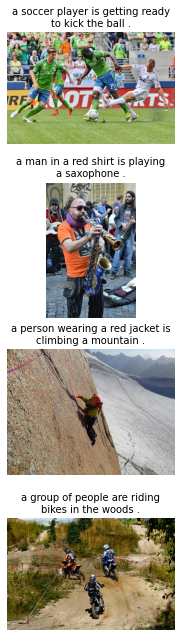

In [0]:
from textwrap import wrap
fig, axs = plt.subplots(4, figsize=(3, 3))

fig.subplots_adjust(top=3)

plotax(axs[0], 10)
plotax(axs[1], 20)
plotax(axs[2], 50)
plotax(axs[3], 14)

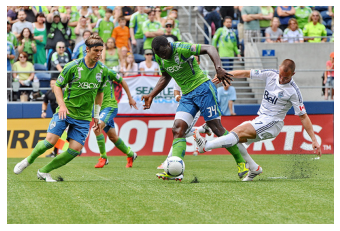

Ground truth:  A game of soccer where the opposing team in trying to gain the ball back .
Prediction-greedy: a soccer player is getting ready to kick the ball . 


In [0]:
i = 10
plt.imshow(Image.open(os.path.join(data_path, data_set.data_files[-1000+i])))
plt.axis('off')
plt.show()
print("Ground truth:", data_set.caption_list[-1000+i])
print("Prediction-greedy:", result_collection[i])

## LSTM+Attention

In [0]:
def token_sentence(decoder_out, itos):
    tokens = decoder_out
    # tokens = decoder_out.argmax(dim=2)
    # tokens = tokens.transpose(1, 0)
    tokens = tokens.cpu().numpy()
    results = []
    for instance in tokens:
        result = ' '.join([itos[x] for x in instance])
        results.append(''.join(result.partition('<eos>')[0])) # Cut before '<eos>'
    return results

In [0]:
encoder.load_state_dict(torch.load(enc_save_path))
decoder.load_state_dict(torch.load(dec_save_path))
encoder.eval()
decoder.eval()

In [0]:
itos = data_set.field.vocab.itos
pred_len = data_set.seq_len
result_collection = []

# Decode with greedy
with torch.no_grad():
    for batch_index, (inputs, captions, caplens) in enumerate(test_loader):
        inputs, captions = inputs.cuda(), captions.cuda()
        enc_outs = encoder(inputs)
        outputs = decoder.greedy_pred(enc_outs, pred_len)
        result_caption = token_sentence(outputs, itos)
        result_collection.extend(result_caption)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [0]:
itos = data_set.field.vocab.itos
pred_len = data_set.seq_len
result_collection_bs = []

# Decode with beam search
with torch.no_grad():
    for batch_index, (inputs, captions, caplens) in enumerate(test_loader):
        inputs, captions = inputs.cuda(), captions.cuda()
        enc_outs = encoder(inputs)
        outputs = decoder.beam_search_pred(enc_outs, pred_len, beam_size=3)
        result_caption_bs = token_sentence(outputs, itos)
        result_collection_bs.extend(result_caption_bs)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


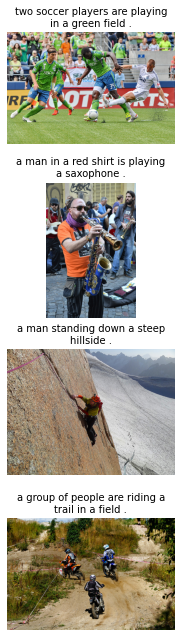

In [0]:
from textwrap import wrap
fig, axs = plt.subplots(4, figsize=(3, 3))

fig.subplots_adjust(top=3)

plotax(axs[0], 10)
plotax(axs[1], 20)
plotax(axs[2], 50)
plotax(axs[3], 14)

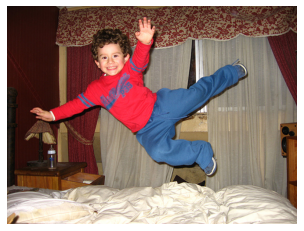

Ground truth:  A curly-haired boy jumps up on a bed .
Prediction-greedy: a girl in a pink shirt is sitting on a couch couch . 
Prediction-beam search: a girl in a pink shirt is sitting on a couch couch . 


In [0]:
i = 8
plt.imshow(Image.open(os.path.join(data_path, data_set.data_files[-1000+i])))
plt.axis('off')
plt.show()
print("Ground truth:", data_set.caption_list[-1000+i])
print("Prediction-greedy:", result_collection[i])
print("Prediction-beam search:", result_collection_bs[i])

## LSTM

In [0]:
def token_sentence(decoder_out, itos):
    tokens = decoder_out
    # tokens = decoder_out.argmax(dim=2)
    tokens = tokens.transpose(1, 0)
    tokens = tokens.cpu().numpy()
    results = []
    for instance in tokens:
        result = ' '.join([itos[x] for x in instance])
        results.append(''.join(result.partition('<eos>')[0])) # Cut before '<eos>'
    return results

In [0]:
encoder.load_state_dict(torch.load(enc_save_path))
decoder.load_state_dict(torch.load(dec_save_path))
encoder.eval()
decoder.eval()

In [0]:
itos = data_set.field.vocab.itos
pred_len = data_set.seq_len
result_collection = []

# Decode with greedy
with torch.no_grad():
    for batch_index, (inputs, captions, caplens) in enumerate(test_loader):
        inputs, captions = inputs.cuda(), captions.cuda()
        enc_outs = encoder(inputs)
        outputs = decoder.greedy_pred(enc_outs, pred_len)
        result_caption = token_sentence(outputs, itos)
        result_collection.extend(result_caption)

In [0]:
itos = data_set.field.vocab.itos
pred_len = data_set.seq_len
result_collection_bs = []

# Decode with beam search
with torch.no_grad():
    for batch_index, (inputs, captions, caplens) in enumerate(test_loader):
        inputs, captions = inputs.cuda(), captions.cuda()
        enc_outs = encoder(inputs)
        outputs = decoder.beam_search_pred(enc_outs, pred_len, beam_size=3)
        result_caption_bs = token_sentence(outputs, itos)
        result_collection_bs.extend(result_caption_bs)

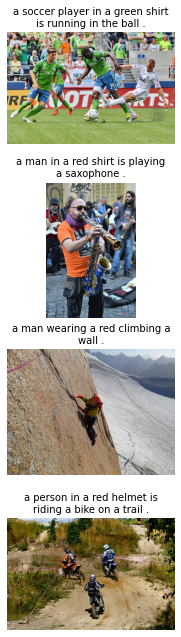

In [0]:
from textwrap import wrap
fig, axs = plt.subplots(4, figsize=(3, 3))

fig.subplots_adjust(top=3)

plotax(axs[0], 10)
plotax(axs[1], 20)
plotax(axs[2], 50)
plotax(axs[3], 14)

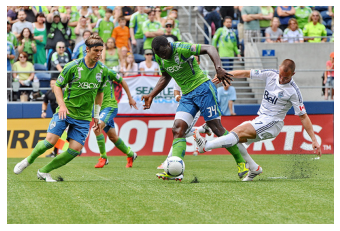

Ground truth:  A game of soccer where the opposing team in trying to gain the ball back .
Prediction-greedy: a soccer player in a green shirt is running in the ball . 
Prediction-beam search: a soccer player in the ball in green shirt . 


In [0]:
i = 10
plt.imshow(Image.open(os.path.join(data_path, data_set.data_files[-1000+i])))
plt.axis('off')
plt.show()
print("Ground truth:", data_set.caption_list[-1000+i])
print("Prediction-greedy:", result_collection[i])
print("Prediction-beam search:", result_collection_bs[i])

## BLEU: Transformer

In [0]:
# Bleu scores w.r.t. all candidates
uni_bleu = bleu_score([x.split(' ') for x in result_collection], reference_corpus[-1000:], max_n=1, weights=[1])
bi_bleu = bleu_score([x.split(' ') for x in result_collection], reference_corpus[-1000:], max_n=2, weights=[1/2]*2)
tri_bleu = bleu_score([x.split(' ') for x in result_collection], reference_corpus[-1000:], max_n=3, weights=[1/3]*3)
qua_bleu = bleu_score([x.split(' ') for x in result_collection], reference_corpus[-1000:], max_n=4, weights=[1/4]*4)
uni_bleu, bi_bleu, tri_bleu, qua_bleu

(0.5564326065958659,
 0.33789987865220567,
 0.2077964192317466,
 0.1296849724024951)

## BLEU: LSTM+Attention

In [0]:
# Bleu scores w.r.t. all candidates
uni_bleu = bleu_score([x.split(' ') for x in result_collection], reference_corpus[-1000:], max_n=1, weights=[1])
bi_bleu = bleu_score([x.split(' ') for x in result_collection], reference_corpus[-1000:], max_n=2, weights=[1/2]*2)
tri_bleu = bleu_score([x.split(' ') for x in result_collection], reference_corpus[-1000:], max_n=3, weights=[1/3]*3)
qua_bleu = bleu_score([x.split(' ') for x in result_collection], reference_corpus[-1000:], max_n=4, weights=[1/4]*4)
uni_bleu, bi_bleu, tri_bleu, qua_bleu

(0.5346815059169459,
 0.31042915545694244,
 0.17528479045322992,
 0.10017493353180056)

## BLEU: LSTM

In [0]:
# Bleu scores w.r.t. all candidates
uni_bleu = bleu_score([x.split(' ') for x in result_collection], reference_corpus[-1000:], max_n=1, weights=[1])
bi_bleu = bleu_score([x.split(' ') for x in result_collection], reference_corpus[-1000:], max_n=2, weights=[1/2]*2)
tri_bleu = bleu_score([x.split(' ') for x in result_collection], reference_corpus[-1000:], max_n=3, weights=[1/3]*3)
qua_bleu = bleu_score([x.split(' ') for x in result_collection], reference_corpus[-1000:], max_n=4, weights=[1/4]*4)
uni_bleu, bi_bleu, tri_bleu, qua_bleu